In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pymystem3 import Mystem
from stop_words import get_stop_words
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import gensim
from gensim.models import word2vec
from sklearn.model_selection import cross_val_predict
import re
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

In [2]:
ads = pd.read_csv('/Users/admin/Documents/contextAdvertising1.csv')

In [3]:
ads.shape

(799999, 3)

In [4]:
ads.head()

,atitle,atext,adomain
0,Клуб активного отдыха «0.67»,Детский пейнтбол. Спортивный пейнтбол. Тактиче...,0-67.relax.by
1,Антигравитационный чехол IPhone 5,Успейте купить антигравитационный чехол для IP...,0-antigravity.ru
2,Антигравитационный чехол купить!,Антигравитационный чехол для телефона купить з...,0-antigravity.ru
3,Беспроцентный заем от Moneyveo,Без справок! Получите до 3 000 грн. на карту п...,0-credit.moneyveo.ua
4,Беспроцентный заем сотруднику,Акция! Получите Кредит Онлайн под 0%. Без Спра...,0-credit.moneyveo.ua


In [5]:
ads.nunique()

atitle     571923
atext      350006
adomain     19181
dtype: int64

In [6]:
(ads['atitle'] + ads['atext']).nunique()

792924

In [7]:
unique_adstext =ads.drop_duplicates(subset = ['atext'], keep=False)

In [8]:
unique_adstext.nunique()

atitle     234515
atext      323003
adomain      4838
dtype: int64

In [9]:
#it appears that even after we remove duplicate ads texts, we still have duplicate titles 
unique_adstext['atitle'].nunique()

234515

In [10]:
unique =unique_adstext.drop_duplicates(subset = ['atitle'], keep=False)

In [11]:
unique.nunique()

atitle     204601
atext      204601
adomain      4589
dtype: int64

In [12]:
unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204601 entries, 0 to 772521
Data columns (total 3 columns):
atitle     204601 non-null object
atext      204601 non-null object
adomain    204601 non-null object
dtypes: object(3)
memory usage: 6.2+ MB


In [13]:
unique.head()

,atitle,atext,adomain
0,Клуб активного отдыха «0.67»,Детский пейнтбол. Спортивный пейнтбол. Тактиче...,0-67.relax.by
1,Антигравитационный чехол IPhone 5,Успейте купить антигравитационный чехол для IP...,0-antigravity.ru
2,Антигравитационный чехол купить!,Антигравитационный чехол для телефона купить з...,0-antigravity.ru
3,Беспроцентный заем от Moneyveo,Без справок! Получите до 3 000 грн. на карту п...,0-credit.moneyveo.ua
4,Беспроцентный заем сотруднику,Акция! Получите Кредит Онлайн под 0%. Без Спра...,0-credit.moneyveo.ua


In [14]:
unique['atext'][:5]

0    Детский пейнтбол. Спортивный пейнтбол. Тактиче...
1    Успейте купить антигравитационный чехол для IP...
2    Антигравитационный чехол для телефона купить з...
3    Без справок! Получите до 3 000 грн. на карту п...
4    Акция! Получите Кредит Онлайн под 0%. Без Спра...
Name: atext, dtype: object

In [15]:
type(unique['atext'])

pandas.core.series.Series

In [16]:
#include all the punctuation signs\n",
def punctuation_remover(row):
    punctuation = '!"#$&\'()*+,-./:;<=>?@[\\]^_`{|}~«»'
    
    punctuationNoPeriod = "[" + re.sub("\.","", punctuation) + "]"
    row = re.sub(punctuationNoPeriod, " ", str(row))
    #to remove double white spaces and create space after %,
    row = row.replace('  ', ' ')
    row = row.replace('%', '% ')
    return row.strip()


In [17]:
punctuation_remover(unique['atext'][0])

'Детский пейнтбол Спортивный пейнтбол Тактический пейнтбол Выездные игры'

In [18]:
# remove punctuation from the ads text
unique['atext'] = unique['atext'].apply(punctuation_remover)

In [19]:
unique['atitle'] = unique['atitle'].apply(punctuation_remover)

In [20]:
unique['atitle'][:5]

0           Клуб активного отдыха 0 67
1    Антигравитационный чехол IPhone 5
2      Антигравитационный чехол купить
3       Беспроцентный заем от Moneyveo
4        Беспроцентный заем сотруднику
Name: atitle, dtype: object

In [21]:
unique['atext'].iloc[0]

'Детский пейнтбол Спортивный пейнтбол Тактический пейнтбол Выездные игры'

In [22]:
unique = unique.drop_duplicates(subset = ['atitle'], keep=False)

In [23]:
unique = unique.drop_duplicates(subset = ['atext'], keep=False)

In [24]:
unique.nunique()

atitle     200718
atext      200718
adomain      4534
dtype: int64

m = Mystem()
def text_parser(series, lemmatize=True): # do lemmatization if true 
    series_copy = series.copy()
 
    # access each ad by index
    for index in series_copy.index:
        
        text = series_copy[index]
        if lemmatize ==True:
            lemmas = m.lemmatize(text)

            lem_no_punct = [lemma for lemma in lemmas if lemma!= ' '
                           and lemma != '\n']
            
            output = lem_no_punct
        else:
            output = text.split()
        series_copy[index] =output
    return series_copy

In [25]:
m = Mystem()
def text_parser(series, lemmatize=True): # do lemmatization if true 
    series_copy = series.copy()
 
    # access each ad by index
    for index in series_copy.index:
        ad_string = ''
        text = series_copy[index]
        if lemmatize == True:
            lemmas = m.lemmatize(text)
            for count, lemma in enumerate(lemmas):
                if (lemma !=  ' ' and lemma != '\n' and count < len(lemmas)):
                    ad_string += lemma +' '
                                
        else:
            resultant_list = text.split()
            for number, word in enumerate(resultant_list):  
                if number <len(resultant_list)-1:
                    ad_string+=word +' '
                    
        series_copy[index] =ad_string.strip()
    return series_copy

In [26]:
unique['atitle'] = text_parser(unique['atitle'])

In [27]:
unique['atext'] = text_parser(unique['atext'])

In [28]:
unique.head()

,atitle,atext,adomain
0,клуб активный отдых 0 67,детский пейнтбол спортивный пейнтбол тактическ...,0-67.relax.by
1,антигравитационный чехол IPhone 5,успевать купить антигравитационный чехол для I...,0-antigravity.ru
3,беспроцентный заем от Moneyveo,без справка получать до 3 000 грн на карта под...,0-credit.moneyveo.ua
4,беспроцентный заем сотрудник,акция получать кредит онлайн под 0 % без спр...,0-credit.moneyveo.ua
11,Аnti Gravity Case,Аnti gravity case – уникальный антигравитаци...,0-gravity.online-shop-2017.ru


In [29]:
unique.shape

(200718, 3)

In [30]:
unique = unique.drop_duplicates(subset = ['atitle'], keep=False)

In [31]:
unique = unique.drop_duplicates(subset = ['atext'], keep=False)

In [32]:
unique.shape

(195820, 3)

In [33]:
unique.nunique()

atitle     195820
atext      195820
adomain      4492
dtype: int64

In [34]:
unique = unique.drop_duplicates(keep=False)

In [35]:
unique.nunique()

atitle     195820
atext      195820
adomain      4492
dtype: int64

In [36]:
unique.shape

(195820, 3)

In [37]:
len(set(unique['atext']))

195820

In [38]:
len(set(unique['atitle']))

195820

In [39]:
len(unique['atitle'])

195820

In [40]:
len(unique['atext'])

195820

In [41]:
unique.isnull().sum()

atitle     0
atext      0
adomain    0
dtype: int64

In [42]:
unique['atitle'] = unique['atitle'].apply(lambda x: x.split())

In [43]:
unique['atext'] = unique['atext'].apply(lambda x: x.split())

In [44]:
X = unique['atext']
y = unique['atitle']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [46]:
merged_list = X_train + y_train

# Training Word2Vec

In [47]:
model = word2vec.Word2Vec(
    merged_list,
    workers=4,     
    min_count=5,   
    window=50,      
    sg=0,          
    sample=1e-4 ,  
    size=300,      
    hs=1           
)


In [48]:
vocab = model.wv.vocab.keys()
print(len(vocab))

21000


In [49]:
def tsne_plot(model):
    #Creates and TSNE model and plots it
    
    labels = []
    tokens = []

    for word in model.wv.vocab:
        if model.wv.vocab[word].count > 800:
            tokens.append(model[word])
            labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=108)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

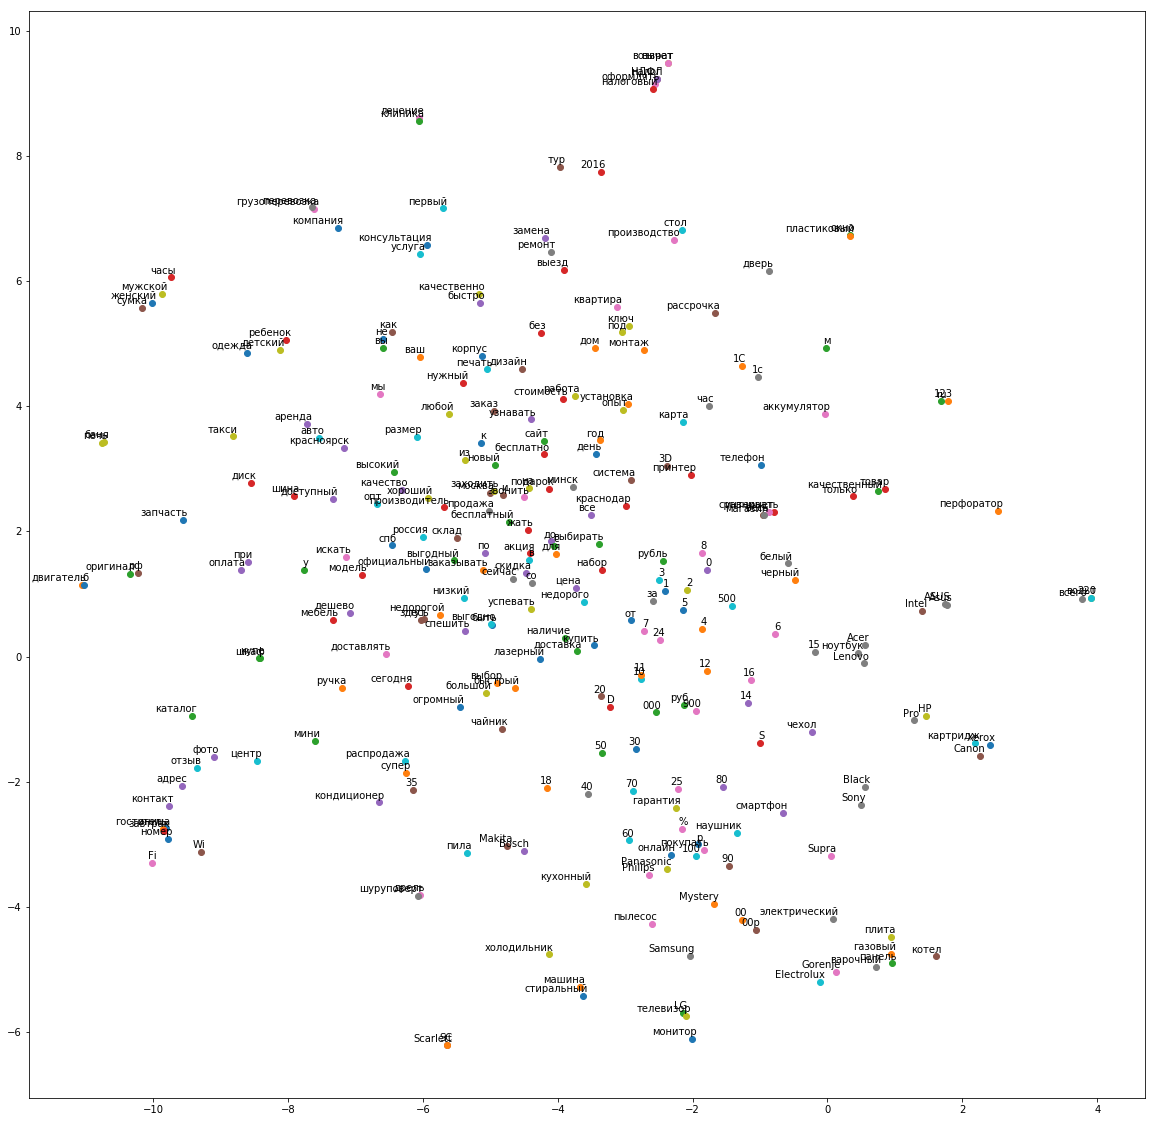

In [50]:
tsne_plot(model)

# Sample For Evaluation

In [51]:
indices = X_test.index

In [52]:
test_df = pd.DataFrame(X_test, index = indices)

In [53]:
test_df.head()

,atext
379691,"[электрочайник, Zigmund, Shtain, KE, 81, SD, 1..."
520472,"[сабвуфер, огромный, ассортимент, бесплатный, ..."
19942,"[Onkyo, Tx, nr545, Black, в, наличие, быстрый,..."
153486,"[шаблон, ордер, входить, в, состав, сборник, 1..."
700377,"[шпаклевка, финишный, белый, сравнивать, цена,..."


In [54]:
test_df['atitle'] = y_test

In [55]:
test_df.shape

(58746, 2)

In [56]:
# we can't fit all the examples in our memory

test_sample = test_df.sample(1000)

In [57]:
test_text_sample = test_sample['atext']
test_title_sample = test_sample['atitle']

In [58]:
from sklearn.preprocessing import normalize


def result_vector(text):
    result = np.zeros(300)
    count = 0
    for word in text:
        if word in vocab:
            result+=model.wv[word]
            count+=1
    if count == 0:
        return None
    #result = (result / count).reshape(1, -1)
    result = normalize(result.reshape(1, -1))     
    return result

In [59]:
ad_vectors = []
for ad_text in test_text_sample:
        vector = result_vector(ad_text)
        if vector is not None:
            ad_vectors.append(vector)
        else:
            ad_vectors.append('M')

In [179]:
title_vectors = []
for ad_title in test_title_sample:
    vector = result_vector(ad_title)
    if vector is not None:
        title_vectors.append(vector)
    else:
        title_vectors.append('M')

In [61]:
def cosine_calculator(vector_one, other_vectors):
    cosines = []
    for each in other_vectors:
        if each != 'M':
            sim_score = cosine_similarity(vector_one, each)
            cosines.extend(sim_score) 
        else:
            cosines.append('M')
    return cosines

In [62]:
def rank_checker(first_vector_set, other_vectors, smpl_df, number):
    cosines_results = cosine_calculator(first_vector_set[number], other_vectors)
    series = pd.Series(cosines_results, index =smpl_df.index)
    
    #cleaning the series for sorting, 'M' stands for missing, was added if no words in the text were found in w2v vocab
    cleaned = series[series != 'M']
    sorted_df = cleaned.sort_values(ascending=False)
    sorted_index = sorted_df.index
    
    for rank, entry in enumerate(sorted_index):
        if entry == smpl_df.index[number]:
            return rank

In [63]:
ranks = []
for row in range(len(test_sample)):
    rank = rank_checker(ad_vectors, title_vectors, test_sample, row)
    ranks.append(rank)

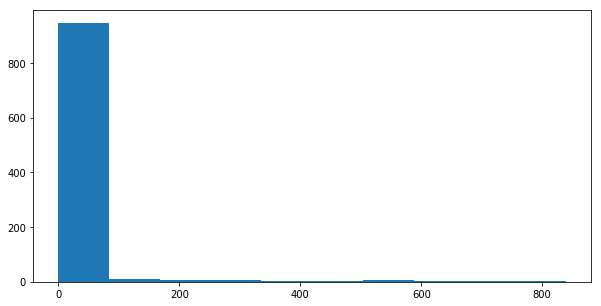

In [64]:
plt.figure(figsize=(10, 5))
plt.hist([rank for rank in ranks if rank is not None])
plt.show()

In [65]:
#average rank
sum([rank for rank in ranks if rank is not None])/ len([rank for rank in ranks if rank is not None])

21.678391959798994

In [66]:
small = []
for rank in ranks:
    if rank is not None and rank <=10:
        small.append(rank) 

In [67]:
# proportion ranked as 
len(small) / len([rank for rank in ranks if rank is not None])

0.8733668341708543

# Supervised Solution

In [68]:
training_df = pd.DataFrame()
training_df['text vectors'] = X_train 
training_df['title vectors'] = y_train

In [69]:
test_df = pd.DataFrame()
test_df['text vectors'] = X_test
test_df['title vectors'] = y_test

In [70]:
training_df.shape

(137074, 2)

In [71]:
test_df.shape

(58746, 2)

In [72]:
def mixed_df_creator(df):
    
    df_copy = df.copy()
    df_copy = df.reset_index(drop=True)
    
    first_half = df_copy.iloc[:int(len(df_copy)/2)]
    second_half = df_copy.iloc[int(len(df_copy)/2):]
    
    shuffled_titles = shuffle(second_half['title vectors'])
    shuffled_titles = shuffled_titles.reset_index(drop=True)
    
    second_half = second_half.reset_index(drop=True)
    second_half['title vectors'] = shuffled_titles
    
    first_half['pair class'] = 1
    second_half['pair class'] = 0
    
    #sim_score_one = first_half.apply(cosine_between_rows, axis = 1)
    #sim_score_two = second_half.apply(cosine_between_rows, axis = 1)
    
    #print('Mean cosine similarity score: first half', np.mean(sim_score_one))
    #print('Mean cosine similarity score: second half', np.mean(sim_score_two))
    
    concat_result = pd.concat([first_half, second_half], axis=0, ignore_index = True)
    
    return concat_result

In [73]:
training_df_mixed = mixed_df_creator(training_df)

In [74]:
test_df_mixed = mixed_df_creator(test_df)

In [75]:
training_df_mixed.head()

,text vectors,title vectors,pair class
0,"[lg, sh7b, от, 819, 00, доставка]","[lg, sh7b]",1
1,"[нужный, перевод, медицинский, документация, к...","[перевод, медицинский, документация]",1
2,"[результат, на, 3, день, зубной, паста, крест,...","[зубной, паста, крест]",1
3,"[массив, бук, и, дуб, древесный, шпон, ciplex,...","[межкомнатный, дверь, из, россия]",1
4,"[купить, Gerat, лента, пробивной, Gerat, 19мм,...","[Gerat, 19мм, 3, 2мм, 30м, 50327]",1


In [76]:
training_df_mixed.shape

(137074, 3)

In [77]:
len(result_vector(training_df_mixed.iloc[0, 0])[0])

300

In [78]:
# vectorization of the ads text
text_vectors = []
for row in range(len(training_df_mixed)):
    vector = result_vector(training_df_mixed.iloc[row, 0])
    if vector is not None:  
        text_vectors.append(vector[0])
    else:
        text_vectors.append('M')

In [79]:
training_df_mixed_vectorized = training_df_mixed.copy()

In [80]:
training_df_mixed_vectorized['text vectors'] = text_vectors

In [81]:
# vectorization of the ads text
text_vectors_test = []
for row in range(len(test_df_mixed)):
    vector = result_vector(test_df_mixed.iloc[row, 0])
    if vector is not None:  
        text_vectors_test.append(vector[0])
    else:
        text_vectors_test.append('M')

In [82]:
test_df_mixed_vectorized = test_df_mixed.copy()

In [83]:
test_df_mixed_vectorized['text vectors'] = text_vectors_test

In [84]:
# vectorization of the ads title
title_vectors_tr = []
for row in range(len(training_df_mixed)):
    vector = result_vector(training_df_mixed.iloc[row, 1])
    if vector is not None:  
        title_vectors_tr.append(vector[0])
    else:
        title_vectors_tr.append('M')

In [85]:
training_df_mixed_vectorized['title vectors'] = title_vectors_tr

In [86]:
# vectorization of the ads title
title_vectors_test = []
for row in range(len(test_df_mixed)):
    vector = result_vector(test_df_mixed.iloc[row, 1])
    if vector is not None:  
        title_vectors_test.append(vector[0])
    else:
        title_vectors_test.append('M')

In [87]:
test_df_mixed_vectorized['title vectors'] = title_vectors_test

In [88]:
# remove vectors with that are comprised exclusively of the words that are missing from our vocabulary

training_df_mixed_vectorized= training_df_mixed_vectorized[training_df_mixed_vectorized['text vectors'] != 'M']
training_df_mixed_vectorized = training_df_mixed_vectorized[training_df_mixed_vectorized['title vectors'] != 'M']

test_df_mixed_vectorized= test_df_mixed_vectorized[test_df_mixed_vectorized['text vectors'] != 'M']
test_df_mixed_vectorized = test_df_mixed_vectorized[test_df_mixed_vectorized['title vectors'] != 'M']

In [89]:
training_df_mixed_vectorized.head()

,text vectors,title vectors,pair class
0,"[0.01695054995571953, 0.04608391156769124, 0.1...","[0.019677669841633987, 0.027117370848279112, 0...",1
1,"[0.0297132702631313, 0.1543718921572532, -0.02...","[0.022622904520389276, 0.16249493608833382, -0...",1
2,"[0.020543536148751523, 0.03808525783003923, 0....","[0.05691170055656063, 0.019291936130919687, 0....",1
3,"[0.0009807624840399145, -0.016426845006617917,...","[-0.00546912440495362, -0.007555954771221714, ...",1
4,"[0.02838815927302891, 0.03459733901852035, 0.0...","[0.029224103071064565, -0.016956976292576684, ...",1


In [90]:
test_df_mixed_vectorized.head()

,text vectors,title vectors,pair class
0,"[0.03816810329803067, 0.04412421624319716, 0.1...","[0.059656564453053264, 0.045308673243519185, 0...",1
1,"[-0.0036939520477964442, 0.05393681718870254, ...","[0.0441408530710877, -0.0027612615336370617, 0...",1
2,"[-0.06671670905980331, 0.0031810948990529746, ...","[-0.09311037864112097, -0.025772691680729366, ...",1
3,"[-0.006508055938034276, 0.11122935097009876, 0...","[0.029982551974415454, 0.10544026507673036, 0....",1
4,"[0.005962386628523769, -0.0003985486689071451,...","[-0.02428248010137484, -0.004550992990763728, ...",1


In [91]:
def cosine_between_rows(row):
    sim = cosine_similarity(row['text vectors'].reshape(1, -1), row['title vectors'].reshape(1, -1))
    return sim

# Cosine Consistency Check

In [92]:
sim_score_one = training_df_mixed_vectorized.iloc[:int(len(training_df_mixed_vectorized)/2)].apply(cosine_between_rows, axis = 1)
sim_score_two = training_df_mixed_vectorized.iloc[int(len(training_df_mixed_vectorized)/2):].apply(cosine_between_rows, axis = 1)

print('Mean cosine similarity score: first half', np.mean(sim_score_one))
print('Mean cosine similarity score: second half', np.mean(sim_score_two))

Mean cosine similarity score: first half [[0.77793142]]
Mean cosine similarity score: second half [[0.23975193]]


In [93]:
sim_score_one_test = test_df_mixed_vectorized.iloc[:int(len(test_df_mixed_vectorized)/2)].apply(cosine_between_rows, axis = 1)
sim_score_two_test = test_df_mixed_vectorized.iloc[int(len(test_df_mixed_vectorized)/2):].apply(cosine_between_rows, axis = 1)

print('Mean cosine similarity score: first half', np.mean(sim_score_one_test))
print('Mean cosine similarity score: second half', np.mean(sim_score_two_test))

Mean cosine similarity score: first half [[0.77131054]]
Mean cosine similarity score: second half [[0.24410764]]


In [94]:
training_df_mixed.head()

,text vectors,title vectors,pair class
0,"[lg, sh7b, от, 819, 00, доставка]","[lg, sh7b]",1
1,"[нужный, перевод, медицинский, документация, к...","[перевод, медицинский, документация]",1
2,"[результат, на, 3, день, зубной, паста, крест,...","[зубной, паста, крест]",1
3,"[массив, бук, и, дуб, древесный, шпон, ciplex,...","[межкомнатный, дверь, из, россия]",1
4,"[купить, Gerat, лента, пробивной, Gerat, 19мм,...","[Gerat, 19мм, 3, 2мм, 30м, 50327]",1


In [95]:
training_df_mixed.isnull().sum()

text vectors     0
title vectors    0
pair class       0
dtype: int64

In [96]:
training_df_mixed.head()

,text vectors,title vectors,pair class
0,"[lg, sh7b, от, 819, 00, доставка]","[lg, sh7b]",1
1,"[нужный, перевод, медицинский, документация, к...","[перевод, медицинский, документация]",1
2,"[результат, на, 3, день, зубной, паста, крест,...","[зубной, паста, крест]",1
3,"[массив, бук, и, дуб, древесный, шпон, ciplex,...","[межкомнатный, дверь, из, россия]",1
4,"[купить, Gerat, лента, пробивной, Gerat, 19мм,...","[Gerat, 19мм, 3, 2мм, 30м, 50327]",1


In [97]:
test_df_mixed.isnull().sum()

text vectors     0
title vectors    0
pair class       0
dtype: int64

In [207]:
def df_converter(df):
    resultant_lists = df['text vectors'].apply(list) + df['title vectors'].apply(list)
    
    #print length for checking the length of concatenated vectors
    print(len(resultant_lists.iloc[0]))
    
    arrays = np.array(list(resultant_lists))
    return arrays

In [175]:
test_sample.head()

,atext,atitle
722354,"[вычет, на, продажа, квартира, оформлять, возв...","[вычет, на, продажа, квартира]"
698279,"[фотоэпилятор, сравнивать, цена, весь, интерне...",[фотоэпилятор]
13032,"[в, наличие, за, 32779, руб, купить]","[HP, 17, x009ur]"
519539,"[аквариум, 50, литр, в, магазин, биотоп, широк...","[аквариум, 50, литр]"
194913,"[купить, Electrolux, встраивать, электрический...","[Electrolux, EOB, 93410, AX, EOB93410A]"


In [176]:
test_sample.shape

(1000, 2)

In [192]:
concatenated_texts_titles_test = df_converter_test(ad_vectors, title_vectors)

300


In [99]:
all_training_vectors = df_converter(training_df_mixed_vectorized)

600


In [100]:
all_test_vectors = df_converter(test_df_mixed_vectorized)

600


In [101]:
new_y_training = training_df_mixed_vectorized['pair class']

In [102]:
new_y_test = test_df_mixed_vectorized['pair class']

# Sample for Parameter Finetuning

In [103]:
sample_training_df = training_df_mixed_vectorized.sample(10000)

In [104]:
sample_training_df.head()

,text vectors,title vectors,pair class
73848,"[-0.024461163648745125, 0.07385958251456846, -...","[0.09777075576446484, -0.017477688958758966, 0...",0
41474,"[0.029550488879790324, -0.0007050228360854501,...","[0.04088338147201241, -0.008635741477812502, 0...",1
71888,"[0.07519309326942628, 0.0020413550882636944, 0...","[-0.04150392343382974, -0.027029322814594935, ...",0
67770,"[0.014005950609526377, 0.07399886373448118, 0....","[0.005792041917937523, 0.01267497323845349, 0....",1
130152,"[-0.0334350553809342, 0.10968606998876124, 0.0...","[0.04067004056744627, 0.03655720860357577, 0.0...",0


In [375]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 150)
X_train_pca = pca.fit_transform(all_training_vectors)

In [376]:
print(sum(pca.explained_variance_ratio_))

0.9633333080771805


In [386]:
X_test_pca = pca.transform(all_test_vectors)

In [387]:
X_test_pca.shape

(58275, 250)

# Finetuning Models

In [108]:
sample_training_arrays = df_converter(sample_training_df)

600


In [109]:
sample_y = sample_training_df['pair class']

In [110]:
pca_sample = PCA(n_components = 150)
X_train_sample_pca = pca_sample.fit_transform(sample_training_arrays)

In [111]:
X_train_sample_pca.shape

(10000, 150)

In [112]:
print(sum(pca_sample.explained_variance_ratio_))

0.878388222000111


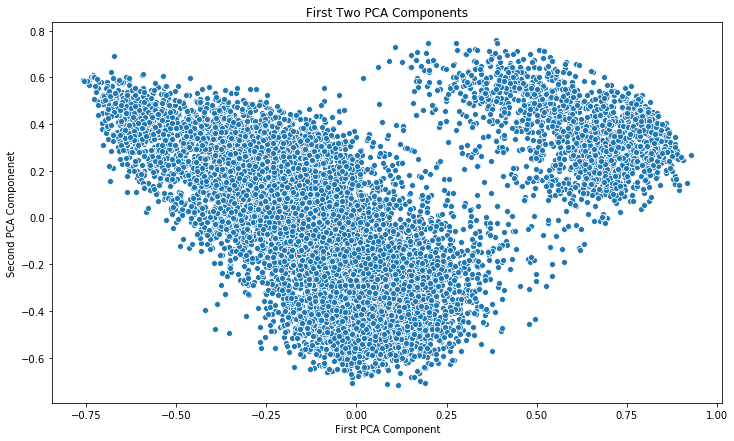

In [113]:
plt.figure(figsize=(12, 7))
plt.title('First Two PCA Components')
sns.scatterplot(X_train_sample_pca[:, 0], X_train_sample_pca[:, 1])
plt.xlabel('First PCA Component')
plt.ylabel('Second PCA Componenet')

plt.show()

In [114]:
from sklearn.linear_model import LogisticRegression

param_grid = [
    {'C': [1e-20, 1e-3,1e-3,  10, 1e2, 1e3],
    'penalty': ['l1', 'l2']}
]
lr = LogisticRegression()

grid_search = GridSearchCV(lr, param_grid, cv =3,
                          scoring= 'accuracy', verbose=1)

grid_search.fit(X_train_sample_pca, sample_y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    2.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [1e-20, 0.001, 0.001, 10, 100.0, 1000.0], 'penalty': ['l1', 'l2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [115]:
print('Best score', grid_search.best_score_)
print('Best parameters', grid_search.best_params_)

Best score 0.5001
Best parameters {'C': 1e-20, 'penalty': 'l1'}


In [116]:
param_grid_rfc = [
    {'n_estimators': [100, 500, 700],
    'max_depth': [5, 8, 12, 20, 30]}
]
rfc = RandomForestClassifier(n_jobs = -1)

grid_search_rfc = GridSearchCV(rfc, param_grid_rfc, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_rfc.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [100, 500, 700], 'max_depth': [5, 8, 12, 20, 30]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [117]:
print('Best score', grid_search_rfc.best_score_)
print('Best parameters', grid_search_rfc.best_params_)

Best score 0.8782
Best parameters {'max_depth': 30, 'n_estimators': 700}


In [118]:
param_grid_rfc = [
    {'n_estimators': [1000, 1200],
    'max_depth': [40, 50]}
]
rfc_one = RandomForestClassifier(n_jobs = -1)

grid_search_rfc_one = GridSearchCV(rfc, param_grid_rfc, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_rfc_one.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [1000, 1200], 'max_depth': [40, 50]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [119]:
print('Best score', grid_search_rfc_one.best_score_)
print('Best parameters', grid_search_rfc_one.best_params_)

Best score 0.8783
Best parameters {'max_depth': 50, 'n_estimators': 1000}


In [120]:
from xgboost import XGBClassifier

param_grid_xgb = [
    {'n_estimators': [100, 500, 700],
    'max_depth': [2, 4, 6, 8],
    #'learning_rate': [1e-3, 0.5, 0.1],
    }
]
xgb = XGBClassifier(n_jobs = -1)

grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_xgb.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [100, 500, 700], 'max_depth': [2, 4, 6, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [121]:
print('Best score', grid_search_xgb.best_score_)
print('Best parameters', grid_search_xgb.best_params_)

Best score 0.9246
Best parameters {'max_depth': 6, 'n_estimators': 700}


In [122]:
param_grid_xgb_one = [
    {'n_estimators': [700, 1000],
    'learning_rate': [1e-3, 0.5, 0.1],
    }
]
xgb = XGBClassifier(n_jobs = -1, max_depth= 6)

grid_search_xgb_one = GridSearchCV(xgb, param_grid_xgb_one, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_xgb_one.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [700, 1000], 'learning_rate': [0.001, 0.5, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [123]:
print('Best score', grid_search_xgb_one.best_score_)
print('Best parameters', grid_search_xgb_one.best_params_)

Best score 0.9278
Best parameters {'learning_rate': 0.1, 'n_estimators': 1000}


In [125]:
param_grid_xgb_two = [
    {'subsample': [0.25, 0.5, 1],
    }
]
xgb = XGBClassifier(n_jobs = -1, max_depth= 6, n_estimators=1000, learning_rate=0.1, )

grid_search_xgb_two = GridSearchCV(xgb, param_grid_xgb_two, cv =3,
                          scoring= 'accuracy', verbose=0,
                          n_jobs = -1)

grid_search_xgb_two.fit(X_train_sample_pca, sample_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'subsample': [0.25, 0.5, 1]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [126]:
print('Best score', grid_search_xgb_two.best_score_)
print('Best parameters', grid_search_xgb_two.best_params_)

Best score 0.9297
Best parameters {'subsample': 0.5}


# Test Set

In [127]:
from sklearn.metrics import roc_auc_score
lr_test = LogisticRegression(C= 1e-20, penalty= 'l1')

lr_test.fit(X_train_pca, new_y_training)

print(lr_test.score(X_test_pca, new_y_test))

0.4997683397683398


In [128]:
rfc_test = RandomForestClassifier(n_jobs = -1, 
                            n_estimators = 1000,
                            max_depth = 50)

rfc_test.fit(X_train_pca, new_y_training)

print(rfc_test.score(X_test_pca, new_y_test))

0.9344487344487344


In [385]:
xgb_test = XGBClassifier(n_estimators = 1000,
                        max_depth = 6,
                        learning_rate= 0.1,
                        subsample = 0.5)

xgb_test.fit(X_train_pca, new_y_training)

print(xgb_test.score(X_test_pca, new_y_test))

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149']
expected f231, f247, f198, f189, f184, f213, f197, f206, f180, f203, f232, f199, f165, f201, f191, f174, f188, f236, f156, f218, f162, f163, f178, f153, f200, f164, f185, f214, f226, f237, f175, f159, f182, f246, f223, f154, f202, f169, f219, f160, f194, f167, f243, f249, f179, f238, f217, f234, f161, f187, f186, f211, f241, f152, f225, f172, f235, f209, f173, f205, f207, f190, f215, f196, f228, f221, f166, f150, f177, f212, f171, f183, f192, f245, f151, f181, f239, f158, f240, f220, f230, f193, f170, f242, f227, f244, f224, f216, f195, f155, f208, f222, f176, f204, f168, f157, f229, f233, f248, f210 in input data

In [388]:
print(xgb_test.score(X_test_pca, new_y_test))

0.9658515658515658


In [130]:
len(X_test_pca)

58275

In [131]:
len(test_df_mixed['text vectors'])

58746

In [132]:
predictions = pd.DataFrame(test_df_mixed['text vectors'].iloc[:200])
predictions['title vectors'] = test_df_mixed['title vectors'].iloc[:200]
predictions['pair class'] = test_df_mixed['pair class'].iloc[:200]
predictions['predicted class'] = xgb_test.predict_proba(X_test_pca[:200])[:, 1]

In [258]:
xgb_test.predict_proba(X_test_pca[0].reshape(1, -1))[:, 1]

array([0.94704723], dtype=float32)

In [133]:
predictions

,text vectors,title vectors,pair class,predicted class
0,"[электрочайник, Zigmund, Shtain, KE, 81, SD, 1...","[KE, 81, SD, 119, 00, р]",1,0.947047
1,"[сабвуфер, огромный, ассортимент, бесплатный, ...","[сабвуфер, купить, в, красноярск]",1,0.998186
2,"[Onkyo, Tx, nr545, Black, в, наличие, быстрый,...","[Onkyo, Tx, nr545, Black, всего, 42390р]",1,0.997832
3,"[шаблон, ордер, входить, в, состав, сборник, 1...","[шаблон, ордер]",1,0.998793
4,"[шпаклевка, финишный, белый, сравнивать, цена,...","[шпаклевка, финишный, белый]",1,0.978355
5,"[акция, аккумулятор, на, Toyota, Corolla, розн...","[аккумулятор, на, Toyota, Corolla]",1,0.997586
6,"[пила, торцовочный, только, сегодня, за, 6499,...","[пила, торцовочный, Hammer]",1,0.995508
7,"[по, низкий, цена, шуруповерт, макит, в, спб, ...","[купить, шуруповерт, макит, в, спб]",1,0.992123
8,"[купить, Makita, уровень, Makita, Skr200z, 174...","[уровень, Makita, Skr200z, 174614]",1,0.998924
9,"[дезодорант, регулир, потоотделение, сравниват...","[дезодорант, регулир, потоотделение]",1,0.993338


In [134]:
predictions = pd.DataFrame(test_df_mixed['text vectors'].iloc[-200:])
predictions['title vectors'] = test_df_mixed['title vectors'].iloc[-200:]
predictions['pair class'] = test_df_mixed['pair class'].iloc[-200:]
predictions['predicted class'] = xgb_test.predict_proba(X_test_pca[-200:])[:, 1]

In [232]:
X_test_pca[0].shape

(150,)

In [135]:
predictions

,text vectors,title vectors,pair class,predicted class
58546,"[адресный, табличка, изготовление, 1, день, бо...","[гостиница, регин, бауман, казань]",0,0.001065
58547,"[телефон, Highscreen, Boost, сравнивать, цена,...","[бампер, на, хонда]",0,0.000347
58548,"[электродный, котел, сравнивать, цена, весь, и...","[Braun, J300, CBD00000788, недорого]",0,0.000418
58549,"[быть, в, наличие, сейчас, рубанок, BLACK, AND...","[налоговый, доход, 2016, год]",0,0.000950
58550,"[мфу, Brother, DCP, J100, 360, 86, р, гарантия...","[Damixa, 521000000, elara, недорого]",0,0.005560
58551,"[наушник, вкладыш, большой, выбор, наушник, по...","[Panasonic, NI, E410TMTW, 65, 21, р]",0,0.000307
58552,"[звонить, сейчас, купить, дом, на, авито, стро...","[TS, WX305T, 263, 10, р]",0,0.043286
58553,"[имплантация, и, профессиональный, протезирова...","[ремонт, конусный, дробилка]",0,0.000224
58554,"[холодильник, Liebherr, CTP, 3316, низкий, цен...","[Tamron, SP, AF, 17, 50мм, F2, 8, Di, II, L]",0,0.060258
58555,"[жакет, теплый, сравнивать, цена, весь, интерн...","[зарядка, для, iphone, 5, belkin]",0,0.025551


In [136]:
from sklearn.metrics import f1_score
print(f1_score(new_y_test, xgb_test.predict(X_test_pca)))

0.9642863289788471


In [137]:
from sklearn.metrics import confusion_matrix
confusion_matrix(new_y_test, xgb_test.predict(X_test_pca))

array([[28187,   937],
       [ 1138, 28013]])

In [138]:
28307 / (577+28307)

0.9800235424456446

In [139]:
28307 / (28307+918)

0.9685885372112917

In [454]:
sample_test_df_checking = test_df.sample(1000)

In [455]:
sample_test_df_checking = sample_test_df_checking.reset_index(drop=True)

In [456]:
sample_test_df_checking.head()

,text vectors,title vectors
0,"[как, откручивать, секретка, без, ключ, позвон...","[как, откручивать, секретка, без, ключ]"
1,"[медкнижка, недорого, медцентр, м, бауманский]","[медкнижка, недорого]"
2,"[цена, весь, 10540, руб, купить, калибр, масте...","[мастер, штбэ, 2600, 230М]"
3,"[большой, выбор, ростест, компьютер, в, интерн...","[компьютер, в, магазин, 003, ru]"
4,"[по, низкий, цена, дрель, спец, быть, в, налич...","[заказывать, недорогой, дрель, спец, тут]"


In [457]:
sample_text_vectors_test = []
for row in range(len(sample_test_df_checking)):
    vector = result_vector(sample_test_df_checking.iloc[row, 0])
    if vector is not None:  
        sample_text_vectors_test.append(vector[0])
    else:
        sample_text_vectors_test.append('M')

In [458]:
sample_title_vectors_test = []
for row in range(len(sample_test_df_checking)):
    vector = result_vector(sample_test_df_checking.iloc[row, 1])
    if vector is not None:  
        sample_title_vectors_test.append(vector[0])
    else:
        sample_title_vectors_test.append('M')

In [459]:
test_sample_vectorized = sample_test_df_checking.copy()
test_sample_vectorized['text vectors'] = sample_text_vectors_test
test_sample_vectorized['title vectors'] = sample_title_vectors_test

In [460]:
test_sample_vectorized.head()

,text vectors,title vectors
0,"[0.03303190755951865, 0.043656322485523404, 0....","[0.0972787703522985, -0.002542677102252535, 0...."
1,"[0.05268231867622848, 0.004161773813217803, -0...","[0.05725391073807927, 0.06927703799545912, 0.0..."
2,"[0.004669992696851108, -0.007991493975081483, ...","[-0.019670392809173286, -0.0020895669415383223..."
3,"[0.015844035016852182, 0.10624481157358256, 0....","[0.034909931174207966, 0.07632702144724259, 0...."
4,"[0.05200673904559876, 0.05470269275282025, 0.0...","[0.0737352409537774, 0.06555027415087987, 0.06..."


In [461]:
test_sample_vectorized.shape

(1000, 2)

In [462]:
test_sample_vectorized= test_sample_vectorized[test_sample_vectorized['text vectors'] != 'M']
test_sample_vectorized = test_sample_vectorized[test_sample_vectorized['title vectors'] != 'M']

In [463]:
test_sample_vectorized.shape

(990, 2)

In [464]:
def probability_calculator(text_vector, title_vectors):
    probs = []
    for each in title_vectors:
        resultant_list = list(text_vector) +list(each)
        resultant_array = np.array(list(resultant_list))
        
        array_pca_tr = pca.transform(resultant_array.reshape(1,- 1))
        probability = xgb_test.predict_proba(array_pca_tr.reshape(1, -1))[:, 1]
        
        probs.extend(probability)
        
    return probs

In [465]:
def rank_checker_prob (df, number):
    probabilities = probability_calculator(df.iloc[number, 0], df.iloc[:, 1])
    series = pd.Series(probabilities, index =df.index)

    sorted_df = series.sort_values(ascending=False)
    sorted_index = sorted_df.index
    
    for rank, entry in enumerate(sorted_index):
        if entry == df.index[number]:
            return rank

In [294]:
test_sample_vectorized.index[0]

722354

In [295]:
test_sample_vectorized.index

Int64Index([722354, 698279,  13032, 519539, 194913, 381526, 198484,  94853,
            719807, 540100,
            ...
            506933, 190307, 424738, 717815, 354271, 675648, 103840, 632898,
            381158, 155727],
           dtype='int64', length=996)

In [466]:
ranks = []
for row in range(len(test_sample_vectorized)):     
    rank = rank_checker_prob(test_sample_vectorized, row)
    ranks.append(rank)

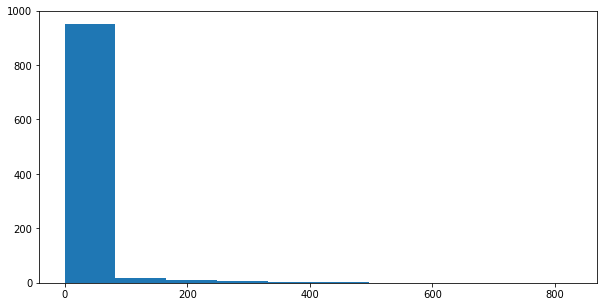

In [467]:
plt.figure(figsize=(10, 5))
plt.hist([rank for rank in ranks if rank is not None])
plt.show()

In [468]:
np.mean(ranks)

12.446464646464646

In [140]:
training_df_mixed.head()

,text vectors,title vectors,pair class
0,"[lg, sh7b, от, 819, 00, доставка]","[lg, sh7b]",1
1,"[нужный, перевод, медицинский, документация, к...","[перевод, медицинский, документация]",1
2,"[результат, на, 3, день, зубной, паста, крест,...","[зубной, паста, крест]",1
3,"[массив, бук, и, дуб, древесный, шпон, ciplex,...","[межкомнатный, дверь, из, россия]",1
4,"[купить, Gerat, лента, пробивной, Gerat, 19мм,...","[Gerat, 19мм, 3, 2мм, 30м, 50327]",1


In [141]:
training_df_mixed.iloc[:5, 1]

0                              [lg, sh7b]
1    [перевод, медицинский, документация]
2                  [зубной, паста, крест]
3       [межкомнатный, дверь, из, россия]
4       [Gerat, 19мм, 3, 2мм, 30м, 50327]
Name: title vectors, dtype: object

In [143]:
merged_trainig_examples = training_df_mixed.iloc[:, 1]+training_df_mixed.iloc[:, 0]

In [144]:
len(merged_trainig_examples)

137074

In [145]:
merged_test_examples = test_df_mixed.iloc[:, 1]+test_df_mixed.iloc[:, 0]

In [146]:
len(merged_test_examples)

58746

In [147]:
max([len(x) for x in merged_trainig_examples])

30

In [148]:
max([len(x) for x in merged_test_examples])

29

In [149]:

def padder(dataset, max_length = 30):

    all_rows = []
    for row in dataset:
        difference = max_length - len(row)
        if difference >0:
            row_list = [word for word in row]
            for times in range(difference):
                row_list.append(0)
        all_rows.append(row_list)
    series = pd.Series(all_rows)
    return series

In [150]:
training_padded = padder(merged_trainig_examples)

In [151]:
test_padded = padder(merged_test_examples)

In [153]:
def vectorizer_of_series(series):
    final_list = []
    for row in series:
        vectorized_pairs = []
        for word in row: 
            if word== 0:
                vectorized_pairs.append(np.zeros(300))
            else:
                if word in vocab:
                    word_emb = model.wv[word]
                    vectorized_pairs.append(word_emb)
                else:
                    vectorized_pairs.append(np.zeros(300))
        final_list.append(vectorized_pairs)
    return final_list

In [154]:
vec_series_training = vectorizer_of_series(training_padded)

In [155]:
final_array_training = np.array(vec_series_training)

In [156]:
vec_series_test = vectorizer_of_series(test_padded)

In [157]:
final_array_test = np.array(vec_series_test)

In [158]:
final_array_training.shape

(137074, 30, 300)

In [159]:
final_array_test.shape

(58746, 30, 300)

In [160]:
len(training_df_mixed['pair class'])

137074

In [161]:
import keras
from keras.utils import to_categorical
y_reshaped_tr = keras.utils.to_categorical(training_df_mixed['pair class'], 2)
y_reshaped_test = keras.utils.to_categorical(test_df_mixed['pair class'], 2)

Using TensorFlow backend.


In [167]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

model_rnn = Sequential()

model_rnn.add(SimpleRNN(units=100, input_shape=(30, 300), activation = 'relu'))

model_rnn.add(Dense(units=2, activation='softmax'))
model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

model_rnn.fit(final_array_training, y_reshaped_tr, epochs=30, verbose = 1, validation_data = (final_array_test, y_reshaped_test))

Train on 137074 samples, validate on 58746 samples
Epoch 1/30
137074/137074 [==============================] - 65s 472us/step - loss: 0.6543 - acc: 0.5933 - val_loss: 0.5471 - val_acc: 0.7259
Epoch 2/30
137074/137074 [==============================] - 66s 481us/step - loss: 0.4855 - acc: 0.7668 - val_loss: 0.4435 - val_acc: 0.7939
Epoch 3/30
137074/137074 [==============================] - 68s 494us/step - loss: 0.4285 - acc: 0.8037 - val_loss: 0.4136 - val_acc: 0.8092
Epoch 4/30
137074/137074 [==============================] - 68s 495us/step - loss: 0.3977 - acc: 0.8221 - val_loss: 0.4062 - val_acc: 0.8179
Epoch 5/30
137074/137074 [==============================] - 67s 492us/step - loss: 0.3779 - acc: 0.8332 - val_loss: 0.3987 - val_acc: 0.8244
Epoch 6/30
137074/137074 [==============================] - 66s 484us/step - loss: 0.3627 - acc: 0.8426 - val_loss: 0.3662 - val_acc: 0.8424
Epoch 7/30
137074/137074 [==============================] - 67s 492us/step - loss: 0.3518 - acc: 0.8494

In [168]:
scores = model_rnn.evaluate(final_array_test, y_reshaped_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.3256272388154744
Test accuracy: 0.8627651244299456


In [384]:
model_rnn.predict(final_array_test)

array([[0.06160137, 0.9383986 ],
       [0.5411746 , 0.45882535],
       [0.2109836 , 0.7890164 ],
       ...,
       [0.45762172, 0.5423782 ],
       [0.22215958, 0.77784044],
       [0.22541952, 0.7745805 ]], dtype=float32)